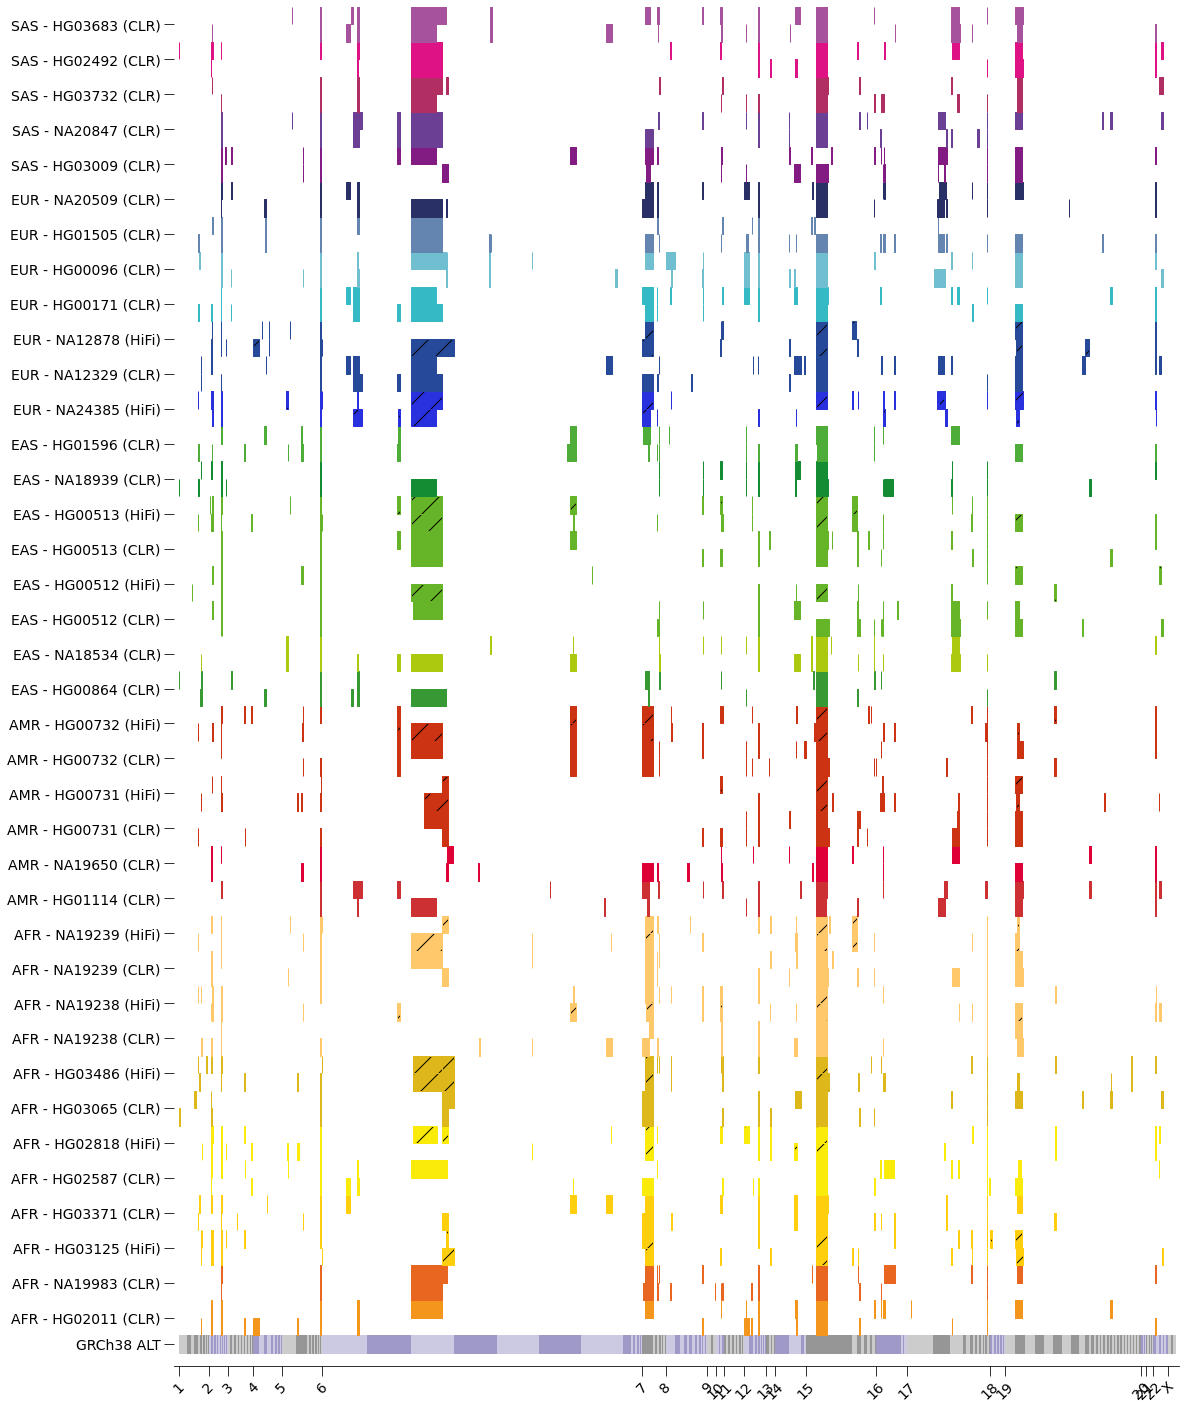

In [1]:
import os
import re
import importlib

import pandas as pd
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt

plot_aux_module = '/home/local/work/code/github/project-diploid-assembly/notebooks/aux_mods/plot_aux.py'
plot_aux_spec = importlib.util.spec_from_file_location("plot_aux", plot_aux_module)
plot_aux = importlib.util.module_from_spec(plot_aux_spec)
plot_aux_spec.loader.exec_module(plot_aux)

samples = plot_aux.load_sample_table()
hexcodes, rgbcodes, popmap = plot_aux.load_population_annotation()

prop = plot_aux.get_plot_property

rgb_rel = plot_aux.relative_rgb
rel_rgb = rgb_rel

ref_contigs = '/home/local/work/pipeline/run_folder/references/assemblies/GRCh38_HGSVC2_incalt.sizes'
contig_aln_folder = '/home/local/work/data/hgsvc/contig_aln_bed_incalt'
min_mapq = 60

save_fig = True

# color definitions
white = (1, 1, 1)
greys = [
    rgb_rel((204,204,204)),
    rgb_rel((150,150,150))
]
purples = [
    rgb_rel((203,201,226)),
    rgb_rel((158,154,200))
]

def load_alt_contigs(fpath):
    
    color_a, color_b = greys, purples
    
    alt_contigs = []
    with open(fpath, 'r') as table:
        for line in table:
            contig, size = line.split()
            if not contig.endswith('_alt'):
                continue
            chrom = contig.split('_')[0]
            try:
                sort_order = int(chrom.strip('chr'))
            except ValueError:
                if chrom == 'chrX':
                    sort_order = 23
                elif chrom == 'chrY':
                    sort_order = 24
                else:
                    continue
            alt_contigs.append((sort_order, int(size), contig))
    
    df = pd.DataFrame.from_records(alt_contigs, columns=['sort_order', 'size', 'chrom'])
    df.sort_values(
        ['sort_order', 'size', 'chrom'],
        ascending=[True, False, True],
        inplace=True
    )
    df.reset_index(drop=True, inplace=True)

    concat_coords = []
    offset = 0
    last_chrom = df.loc[0, 'sort_order']
    for idx, row in df.iterrows():
        if row['sort_order'] != last_chrom:
            color_a, color_b = color_b, color_a
        concat_coords.append((offset, offset + row['size'], color_a[0]))
        color_a[0], color_a[1] = color_a[1], color_a[0]
        offset += row['size']
        last_chrom = row['sort_order']
        
    concat_coords = pd.DataFrame.from_records(
        concat_coords,
        columns=['concat_start', 'concat_end', 'color'],
        index=df.index
    )
    df = pd.concat([df, concat_coords], axis=1, ignore_index=False)
    
    return df


def load_contig_alignments(fpath, alt_contigs):
    
    df = pd.read_csv(
        fpath,
        sep='\t',
        names=['chrom', 'start', 'end', 'contig', 'mapq', 'strand']
    )
    df = df.loc[df['mapq'] >= min_mapq, :].copy()
    df = df.loc[df['chrom'].str.endswith('_alt'), :].copy()
    df = df.merge(alt_contigs, on='chrom', how='left')
    df.sort_values(
        ['sort_order', 'size', 'start', 'end'],
        ascending=[True, False, True, True],
        inplace=True
    )
    
    blocks = []
    current_start = -1
    current_end = -1
    current_chrom = df.loc[df.index[0], 'chrom']
    for idx, row in df.iterrows():
        if row['chrom'] != current_chrom:
            blocks.append((current_start, min(current_end, row['concat_end'])))
            current_start = -1
            current_end = -1
            current_chrom = row['chrom']
        if current_start == -1:
            current_start = row['start'] + row['concat_start']
            current_end = row['end'] + row['concat_start']
        elif current_start > row['start'] + row['concat_start']:
            # overlapping alignments
            current_end = row['end'] + row['concat_start']
        else:
            blocks.append((current_start, min(current_end, row['concat_end'])))
            current_start = row['start'] + row['concat_start']
            current_end = row['end'] + row['concat_start']

    blocks.append((current_start, min(current_end, row['concat_end'])))
    
    blocks = pd.DataFrame(blocks, columns=['start', 'end'])
    return blocks


def load_sample_info(filename, sample_table=samples, rgb_codes=rgbcodes):
    
    if not filename.endswith('incalt.bed'):
        return None
    sample_name = filename.split('_')[0]
    if sample_name in ['HG00733', 'HG00514', 'NA19240']:
        return None
    sample_info = sample_table[sample_name]
    if 'h1-un' in filename:
        hap = 'H1'
    elif 'h2-un' in filename:
        hap = 'H2'
    else:
        raise
    if 'pbsq2-clr' in filename:
        platform = 'CLR'
    elif 'pbsq2-ccs' in filename:
        platform = 'HiFi'
    else:
        raise
    super_pop = sample_info['super_population']
    population = sample_info['population']
    return (super_pop, population, sample_name, platform, hap, rgb_codes[population], filename)


alt_contigs = load_alt_contigs(ref_contigs)

# Figure stuff
width = 18
height = 25

fig, ax = plt.subplots(figsize=(width, height))

x_labels = []
x_label_pos = []
for sort_order, group in alt_contigs.groupby('sort_order'):
    if sort_order == 23:
        chrom = 'X'
    elif sort_order == 24:
        chrom = 'Y'
    else:
        chrom = str(sort_order)
    tick_position = group['concat_start'].min()
    x_labels.append(chrom)
    x_label_pos.append(tick_position)

y_start = 0
y_labels = ['GRCh38 ALT']
y_label_pos = [0.5]
max_plot = 0

# plot alternating color pattern as substitute for cytogenetic bands
barh_xranges = []
barh_colors = []
for idx, contig in alt_contigs.iterrows():
    x_min = contig['concat_start']
    x_width = contig['size']
    x_max = x_min + x_width
    max_plot = max(max_plot, x_max)
    barh_xranges.append((x_min, x_width))
    barh_colors.append(contig['color'])

ax.broken_barh(
    barh_xranges,
    (y_start, 1),
    edgecolor='face',
    facecolors=barh_colors,
    zorder=10
)

y_start += 1

ctg_aln_files = [
    load_sample_info(ctg_aln_file) for ctg_aln_file in os.listdir(contig_aln_folder)
]
ctg_aln_files = [x for x in ctg_aln_files if x is not None]

ctg_aln_files = sorted(ctg_aln_files)

for ctg_aln_info in ctg_aln_files:
    if ctg_aln_info is None:
        continue
    super_pop, pop, sample, platform, hap, color, filename = ctg_aln_info
    ctg_aln_path = os.path.join(contig_aln_folder, filename)
    ctg_aln_blocks = load_contig_alignments(ctg_aln_path, alt_contigs)
    
    barh_xranges = []
    for idx, block in ctg_aln_blocks.iterrows():
        x_min = block['start']
        x_width = block['end'] - block['start']
        x_max = x_min + x_width
        max_plot = max(max_plot, x_max)
        barh_xranges.append((x_min, x_width))

    ax.broken_barh(
        barh_xranges,
        (y_start, 1),
        edgecolor='face',
        facecolors=color,
        hatch='' if platform == 'CLR' else '/',
        zorder=10
    )
    if hap == 'H2':
        y_labels.append('{} - {} ({})'.format(super_pop, sample, platform))
        y_label_pos.append(y_start)
    y_start += 1

# legend = ax.legend(
#     handles=legend_patches,
#     loc='center right',
#     handlelength=3,
#     handleheight=1,
#     prop={'size': 16},
#     title='Phased assembly\ncontig coverage',
#     title_fontsize=16,
#     frameon=False
# )
# legend._legend_box.align = "left"

_ = ax.set_yticks(y_label_pos)
_ = ax.set_yticklabels(y_labels, fontsize=14)
_ = ax.set_xticks(x_label_pos)
_ = ax.set_xticklabels(x_labels, fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(axis='y', which='major', length=10)
ax.tick_params(axis='x', which='major', length=10, rotation=45)

_ = ax.set_xlim(-500000, max_plot // 1e6 * 1e6 + 1e6)
_ = ax.set_ylim(-0.75, y_start)

if save_fig:

    out_path = '/home/local/work/data/hgsvc/figSX_panels/ideograms/figSX_PE_hap-assm-alt-cov_mq{}'.format(min_mapq)    
    
    low_res_dpi = prop('dpi_low_res')
    norm_res_dpi = prop('dpi_norm_res')

    fig.savefig(
        out_path + '.{}dpi.png'.format(low_res_dpi),
        dpi=low_res_dpi,
        bbox_inches='tight'
    )
    
    fig.savefig(
        out_path + '.{}dpi.png'.format(norm_res_dpi),
        dpi=norm_res_dpi,
        bbox_inches='tight'
    )

    fig.savefig(
        out_path + '.svg',
        bbox_inches='tight'
    )